In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style - keep it clean
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Load Results

Let's see what we're working with.

In [2]:
# Load the summary
summary_path = "../predicting_learnability/PIKA_ROUTER_EXPERIMENTS/evaluation_summary.csv"

if Path(summary_path).exists():
    df = pd.read_csv(summary_path)
    print("✅ Loaded evaluation summary")
    print(f"\n📊 Datasets evaluated: {df['dataset'].nunique()}")
    print(f"🔍 Probe sources: {df['probe_source'].nunique()}")
    print(f"\n{display(df)}")
else:
    print("❌ No results found. Run PIKA router first.")
    df = None

✅ Loaded evaluation summary

📊 Datasets evaluated: 4
🔍 Probe sources: 2


,dataset,probe_source,baseline_acc,upper_acc,router_acc,accuracy_gain,token_multiplier,total_cost,results_dir
0,AIME_2025,MATH,0.133333,0.066667,0.066667,-0.066667,1.451412,0.020099,../predicting_learnability/PIKA_ROUTER_EXPERIM...
1,AIME_2025,GSM8K,0.133333,0.066667,0.066667,-0.066667,1.512685,0.020995,../predicting_learnability/PIKA_ROUTER_EXPERIM...
2,E2H-GSM8K,MATH,0.800000,0.933333,0.933333,0.133333,1.006583,0.005144,../predicting_learnability/PIKA_ROUTER_EXPERIM...
3,E2H-GSM8K,GSM8K,0.800000,0.933333,0.933333,0.133333,0.999518,0.005100,../predicting_learnability/PIKA_ROUTER_EXPERIM...
4,GSM_HARD,MATH,0.266667,0.333333,0.333333,0.066667,0.750275,0.005692,../predicting_learnability/PIKA_ROUTER_EXPERIM...
5,GSM_HARD,GSM8K,0.266667,0.333333,0.333333,0.066667,0.751046,0.005699,../predicting_learnability/PIKA_ROUTER_EXPERIM...
6,AIME_1983_2024,MATH,0.200000,0.333333,0.333333,0.133333,1.024354,0.017676,../predicting_learnability/PIKA_ROUTER_EXPERIM...
7,AIME_1983_2024,GSM8K,0.200000,0.333333,0.266667,0.066667,1.195870,0.020824,../predicting_learnability/PIKA_ROUTER_EXPERIM...



None


## 1. Pareto Frontier: Cost vs Accuracy

This is the money plot. Shows if we're actually on the efficiency frontier or just doing something stupid.

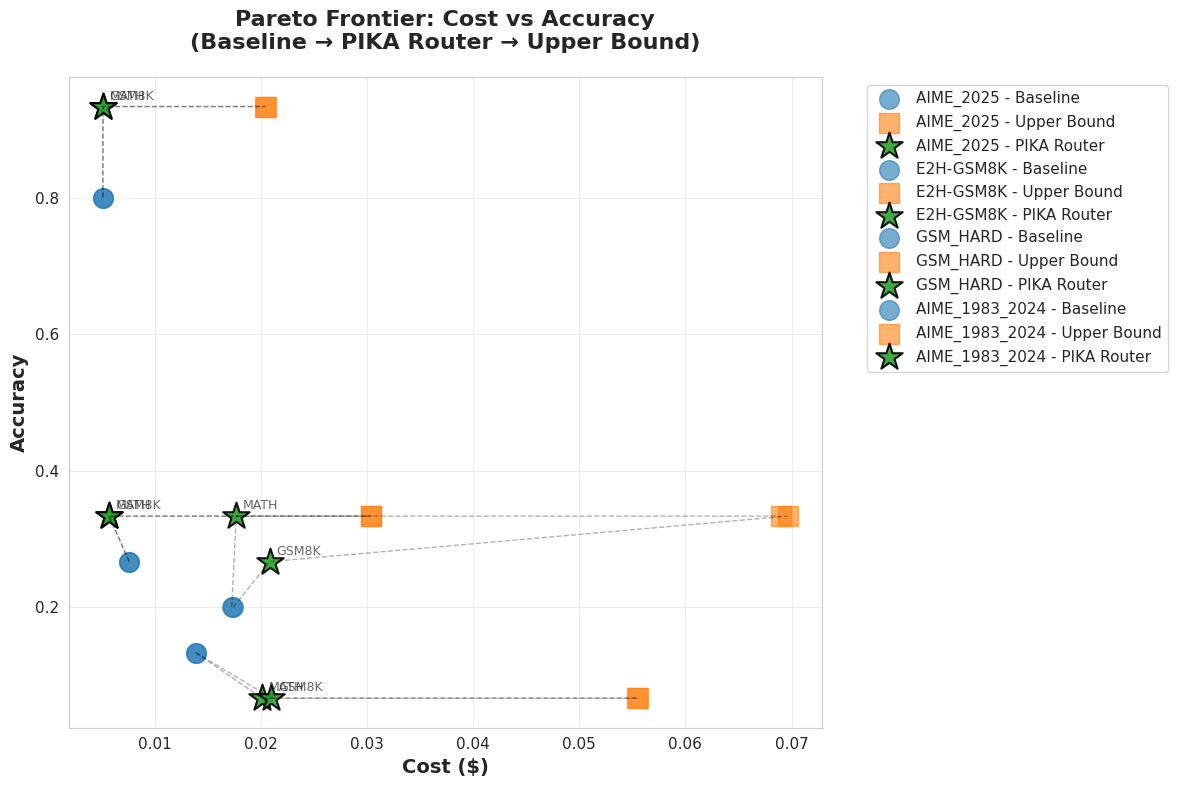


📈 What are we looking at:
• Circles (baseline): Cheap model, probably mid accuracy
• Squares (upper): Expensive model, hopefully better accuracy
• Stars (PIKA): Where we actually land with routing

✨ Ideal scenario: PIKA star is close to upper square but way cheaper


In [3]:
if df is not None:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each dataset
    for dataset in df['dataset'].unique():
        df_subset = df[df['dataset'] == dataset]
        
        for idx, row in df_subset.iterrows():
            # Baseline (cheap model)
            baseline_cost = row['total_cost'] / (row['token_multiplier'] if row['token_multiplier'] > 0 else 1)
            ax.scatter(baseline_cost, row['baseline_acc'], 
                      marker='o', s=200, alpha=0.6, 
                      label=f"{dataset} - Baseline" if idx == df_subset.index[0] else "",
                      color='C0')
            
            # Upper bound (expensive model)
            # Estimate: expensive model is ~4x cost based on config
            upper_cost = baseline_cost * 4  # This is approximate
            ax.scatter(upper_cost, row['upper_acc'], 
                      marker='s', s=200, alpha=0.6,
                      label=f"{dataset} - Upper Bound" if idx == df_subset.index[0] else "",
                      color='C1')
            
            # PIKA Router
            ax.scatter(row['total_cost'], row['router_acc'], 
                      marker='*', s=400, alpha=0.9,
                      label=f"{dataset} - PIKA Router" if idx == df_subset.index[0] else "",
                      color='C2', edgecolors='black', linewidths=1.5)
            
            # Connect the dots to show the frontier
            ax.plot([baseline_cost, row['total_cost'], upper_cost],
                   [row['baseline_acc'], row['router_acc'], row['upper_acc']],
                   'k--', alpha=0.3, linewidth=1)
            
            # Annotate probe source
            ax.annotate(row['probe_source'], 
                       (row['total_cost'], row['router_acc']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, alpha=0.7)
    
    ax.set_xlabel('Cost ($)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('Pareto Frontier: Cost vs Accuracy\n(Baseline → PIKA Router → Upper Bound)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 What are we looking at:")
    print("• Circles (baseline): Cheap model, probably mid accuracy")
    print("• Squares (upper): Expensive model, hopefully better accuracy")
    print("• Stars (PIKA): Where we actually land with routing")
    print("\n✨ Ideal scenario: PIKA star is close to upper square but way cheaper")

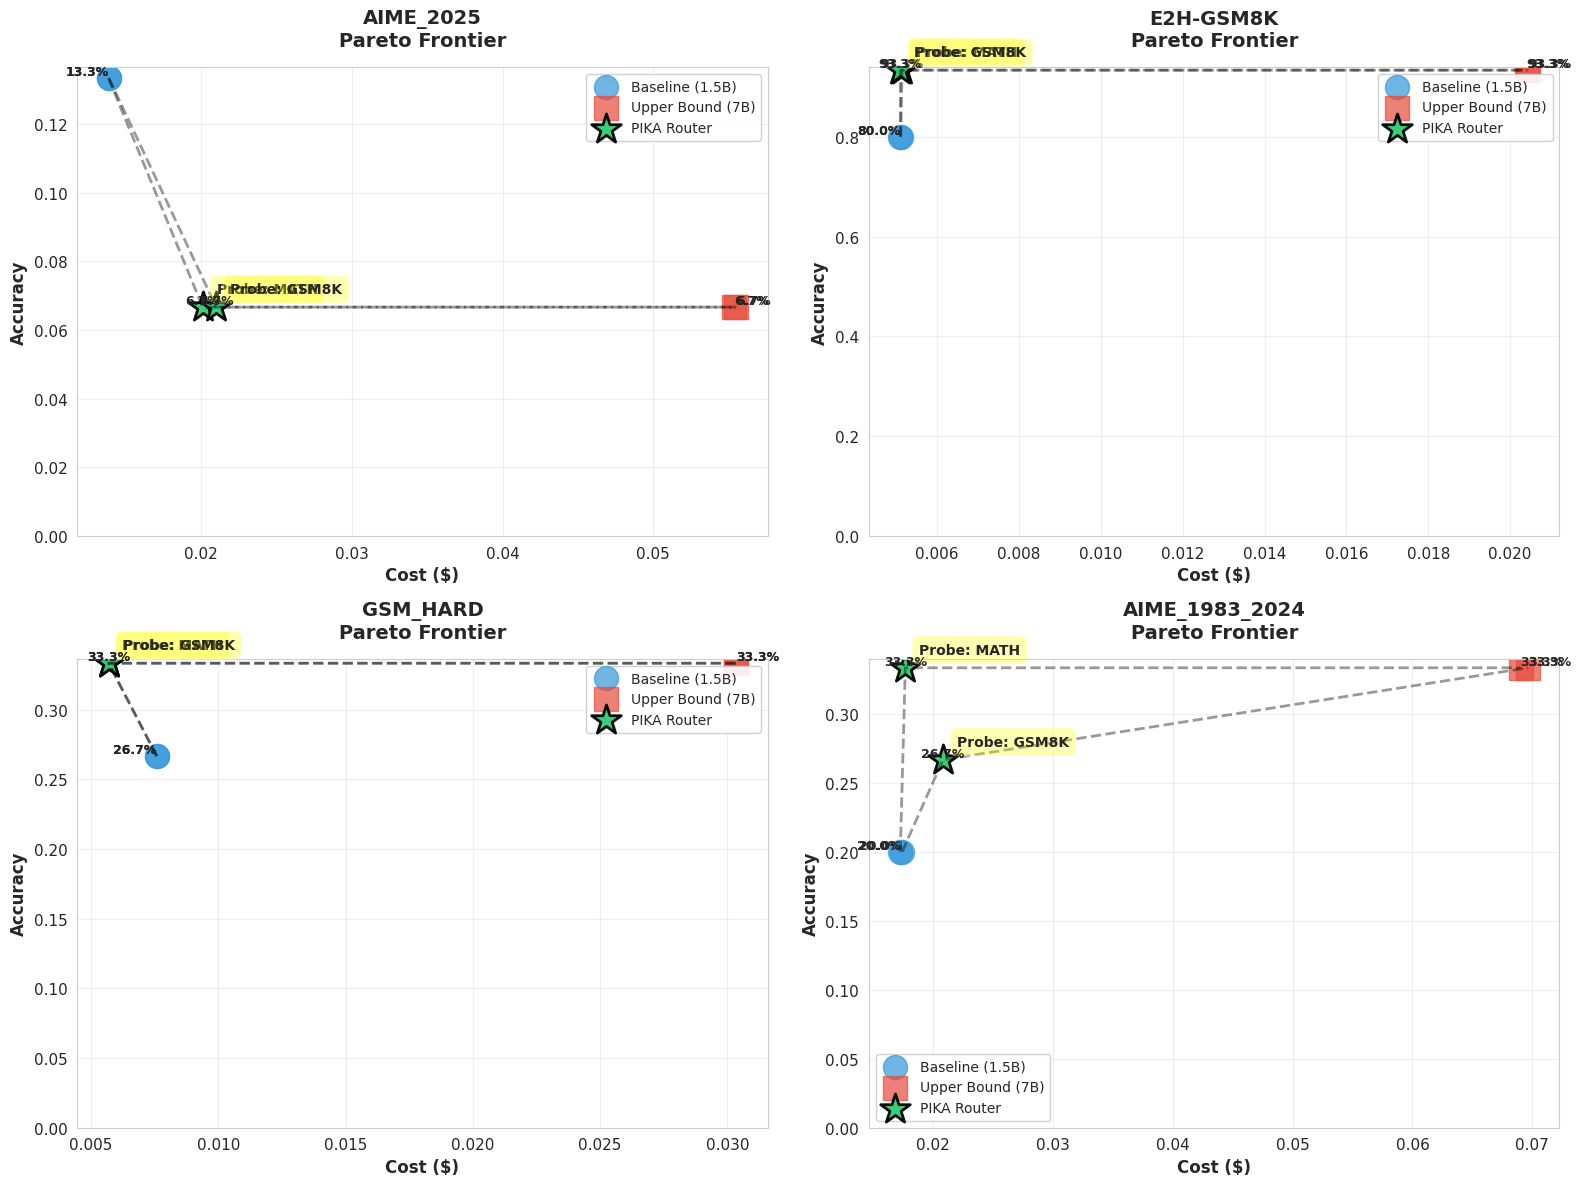


📈 What are we looking at:
• Blue circles: Baseline (Qwen2.5-Math-1.5B) - cheap but limited
• Red squares: Upper Bound (Qwen2.5-Math-7B) - expensive but best possible
• Green stars: PIKA Router - where we actually land with intelligent routing

✨ Ideal scenario: Green star close to red square but way cheaper (closer to blue)

🎯 Each dataset shows different probe sources to compare routing strategies


In [8]:
if df is not None:
    datasets = df['dataset'].unique()
    n_datasets = len(datasets)
    
    # Create subplots - 2 columns, as many rows as needed
    n_cols = 2
    n_rows = (n_datasets + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        df_subset = df[df['dataset'] == dataset]
        
        # Get all probe sources for this dataset
        for row_idx, row in df_subset.iterrows():
            probe = row['probe_source']
            
            # Baseline (cheap model) - estimate from total cost and multiplier
            baseline_cost = row['total_cost'] / (row['token_multiplier'] if row['token_multiplier'] > 0 else 1)
            
            # Upper bound (expensive model) - estimate as 4x baseline
            upper_cost = baseline_cost * 4
            
            # Plot the three points
            ax.scatter(baseline_cost, row['baseline_acc'], 
                      marker='o', s=300, alpha=0.7, 
                      label='Baseline (1.5B)', color='#3498db')
            
            ax.scatter(upper_cost, row['upper_acc'], 
                      marker='s', s=300, alpha=0.7,
                      label='Upper Bound (7B)', color='#e74c3c')
            
            ax.scatter(row['total_cost'], row['router_acc'], 
                      marker='*', s=500, alpha=0.95,
                      label='PIKA Router', color='#2ecc71', 
                      edgecolors='black', linewidths=2)
            
            # Connect the dots
            ax.plot([baseline_cost, row['total_cost'], upper_cost],
                   [row['baseline_acc'], row['router_acc'], row['upper_acc']],
                   'k--', alpha=0.4, linewidth=2)
            
            # Annotate with probe source
            ax.annotate(f"Probe: {probe}", 
                       (row['total_cost'], row['router_acc']),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
            
            # Add accuracy values on points
            ax.text(baseline_cost, row['baseline_acc'], f"{row['baseline_acc']:.1%}",
                   ha='right', va='bottom', fontsize=9, fontweight='bold')
            ax.text(row['total_cost'], row['router_acc'], f"{row['router_acc']:.1%}",
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
            ax.text(upper_cost, row['upper_acc'], f"{row['upper_acc']:.1%}",
                   ha='left', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_xlabel('Cost ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax.set_title(f'{dataset}\nPareto Frontier', 
                    fontsize=14, fontweight='bold', pad=15)
        
        # Only show legend once per plot (remove duplicates)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), 
                 loc='best', framealpha=0.9, fontsize=10)
        
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
    
    # Hide extra subplots if odd number of datasets
    for idx in range(n_datasets, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 What are we looking at:")
    print("• Blue circles: Baseline (Qwen2.5-Math-1.5B) - cheap but limited")
    print("• Red squares: Upper Bound (Qwen2.5-Math-7B) - expensive but best possible")
    print("• Green stars: PIKA Router - where we actually land with intelligent routing")
    print("\n✨ Ideal scenario: Green star close to red square but way cheaper (closer to blue)")
    print("\n🎯 Each dataset shows different probe sources to compare routing strategies")

## 2. Accuracy Gains Breakdown

Let's see where PIKA is actually helping vs just adding complexity.

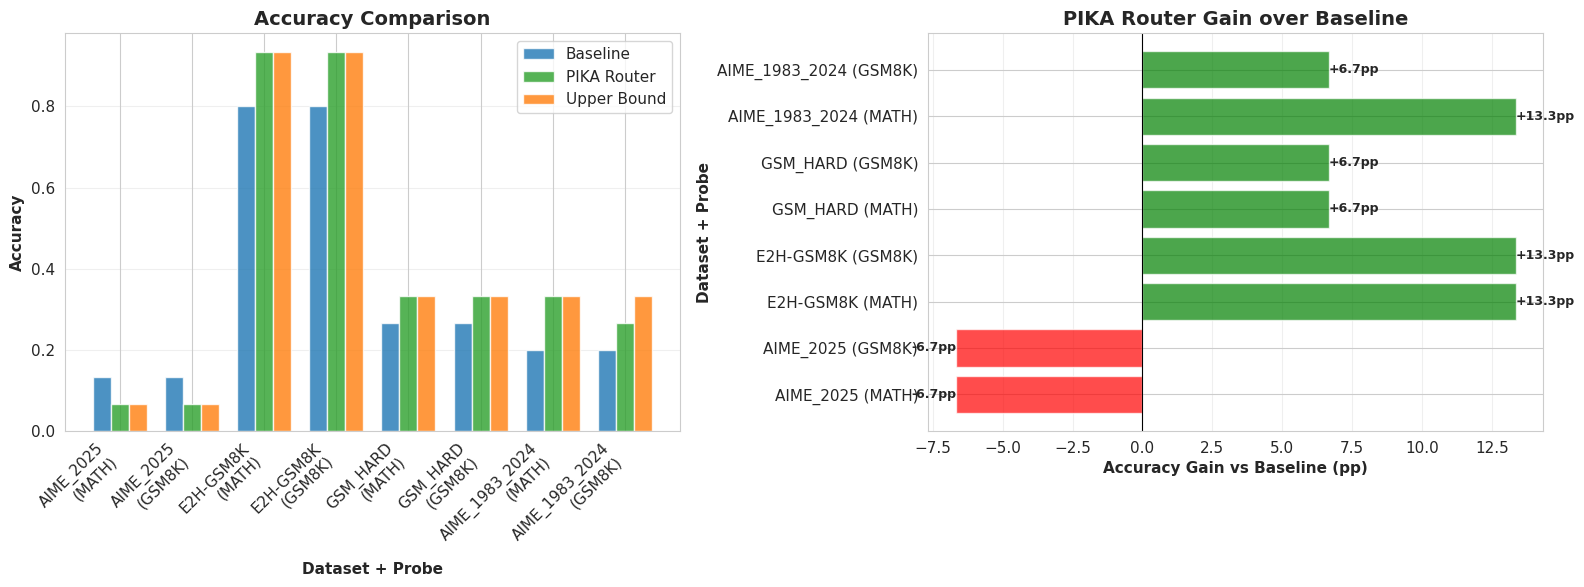


🎯 Key insights:
• Best gain: AIME_1983_2024 (+13.3pp)
• Worst: AIME_2025 (-6.7pp)
• Average gain: +5.8pp


In [4]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Accuracy comparison
    x = np.arange(len(df))
    width = 0.25
    
    bars1 = axes[0].bar(x - width, df['baseline_acc'], width, label='Baseline', alpha=0.8, color='C0')
    bars2 = axes[0].bar(x, df['router_acc'], width, label='PIKA Router', alpha=0.8, color='C2')
    bars3 = axes[0].bar(x + width, df['upper_acc'], width, label='Upper Bound', alpha=0.8, color='C1')
    
    axes[0].set_xlabel('Dataset + Probe', fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontweight='bold')
    axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f"{d}\n({p})" for d, p in zip(df['dataset'], df['probe_source'])], 
                            rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Right: Accuracy gain from baseline
    df['router_vs_baseline'] = (df['router_acc'] - df['baseline_acc']) * 100
    df['router_vs_upper'] = (df['router_acc'] - df['upper_acc']) * 100
    
    colors = ['green' if x > 0 else 'red' for x in df['router_vs_baseline']]
    bars = axes[1].barh(range(len(df)), df['router_vs_baseline'], color=colors, alpha=0.7)
    
    axes[1].set_xlabel('Accuracy Gain vs Baseline (pp)', fontweight='bold')
    axes[1].set_ylabel('Dataset + Probe', fontweight='bold')
    axes[1].set_title('PIKA Router Gain over Baseline', fontsize=14, fontweight='bold')
    axes[1].set_yticks(range(len(df)))
    axes[1].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])])
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df['router_vs_baseline'])):
        axes[1].text(val, i, f'{val:+.1f}pp', 
                    va='center', ha='left' if val > 0 else 'right',
                    fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Key insights:")
    print(f"• Best gain: {df.loc[df['router_vs_baseline'].idxmax(), 'dataset']} ({df['router_vs_baseline'].max():+.1f}pp)")
    print(f"• Worst: {df.loc[df['router_vs_baseline'].idxmin(), 'dataset']} ({df['router_vs_baseline'].min():+.1f}pp)")
    print(f"• Average gain: {df['router_vs_baseline'].mean():+.1f}pp")

## 3. Cost Efficiency: Are We Being Smart?

Token multiplier tells us if we're just burning compute or being clever.

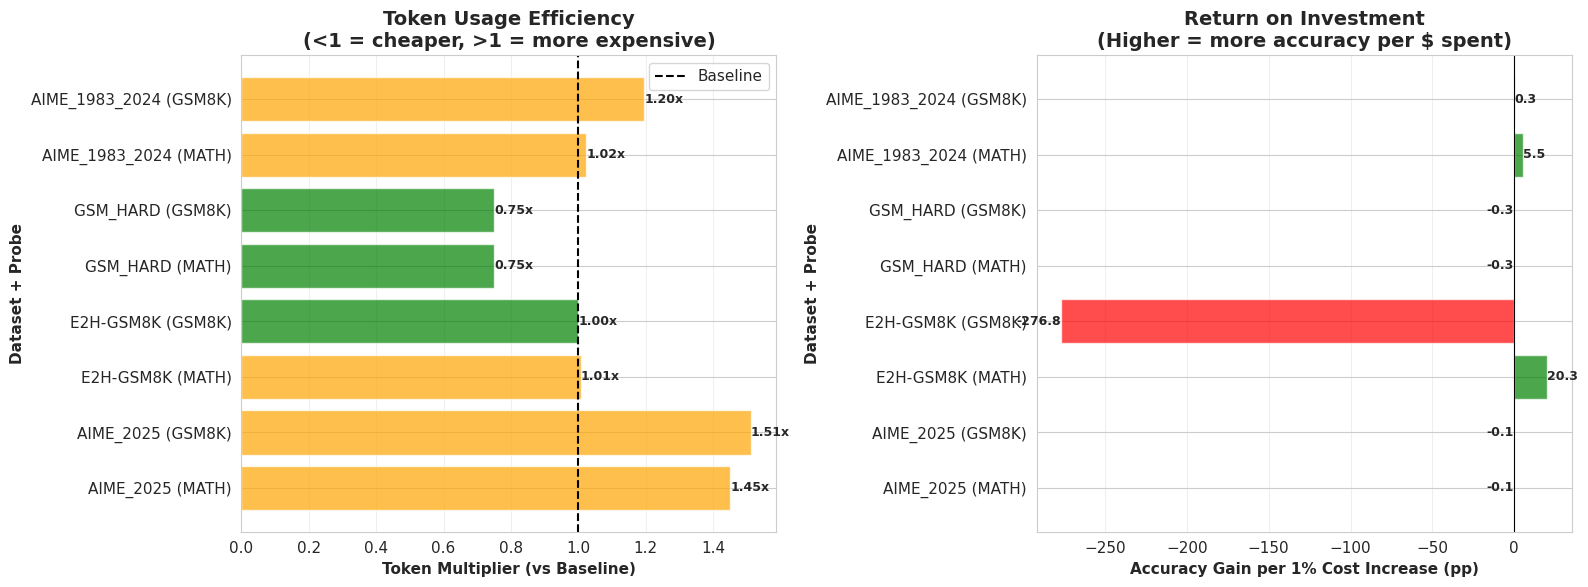


💰 Cost analysis:
• Token multiplier range: 0.75x - 1.51x
• Average: 1.09x
• Configs with token SAVINGS: 3/8


In [5]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Token multiplier
    colors = ['green' if x < 1 else 'orange' if x < 2 else 'red' for x in df['token_multiplier']]
    bars = axes[0].barh(range(len(df)), df['token_multiplier'], color=colors, alpha=0.7)
    
    axes[0].set_xlabel('Token Multiplier (vs Baseline)', fontweight='bold')
    axes[0].set_ylabel('Dataset + Probe', fontweight='bold')
    axes[0].set_title('Token Usage Efficiency\n(<1 = cheaper, >1 = more expensive)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_yticks(range(len(df)))
    axes[0].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])])
    axes[0].axvline(x=1.0, color='black', linestyle='--', linewidth=1.5, label='Baseline')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df['token_multiplier'])):
        axes[0].text(val, i, f'{val:.2f}x', 
                    va='center', ha='left',
                    fontsize=9, fontweight='bold')
    
    # Right: ROI (accuracy gain per cost increase)
    df['cost_increase'] = df['total_cost'] / (df['total_cost'] / df['token_multiplier']) - 1
    df['roi'] = df['router_vs_baseline'] / (df['cost_increase'] * 100)
    df['roi'] = df['roi'].replace([np.inf, -np.inf], np.nan)
    
    if not df['roi'].isna().all():
        colors_roi = ['green' if x > 1 else 'orange' if x > 0 else 'red' for x in df['roi']]
        bars_roi = axes[1].barh(range(len(df)), df['roi'], color=colors_roi, alpha=0.7)
        
        axes[1].set_xlabel('Accuracy Gain per 1% Cost Increase (pp)', fontweight='bold')
        axes[1].set_ylabel('Dataset + Probe', fontweight='bold')
        axes[1].set_title('Return on Investment\n(Higher = more accuracy per $ spent)', 
                         fontsize=14, fontweight='bold')
        axes[1].set_yticks(range(len(df)))
        axes[1].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])])
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars_roi, df['roi'])):
            if not np.isnan(val):
                axes[1].text(val, i, f'{val:.1f}', 
                            va='center', ha='left' if val > 0 else 'right',
                            fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💰 Cost analysis:")
    print(f"• Token multiplier range: {df['token_multiplier'].min():.2f}x - {df['token_multiplier'].max():.2f}x")
    print(f"• Average: {df['token_multiplier'].mean():.2f}x")
    savings = df[df['token_multiplier'] < 1]
    if len(savings) > 0:
        print(f"• Configs with token SAVINGS: {len(savings)}/{len(df)}")
    else:
        print("• No configs with token savings (we're spending more everywhere)")

## 4. Probe Source Comparison

MATH vs GSM8K probe - which one is actually good?

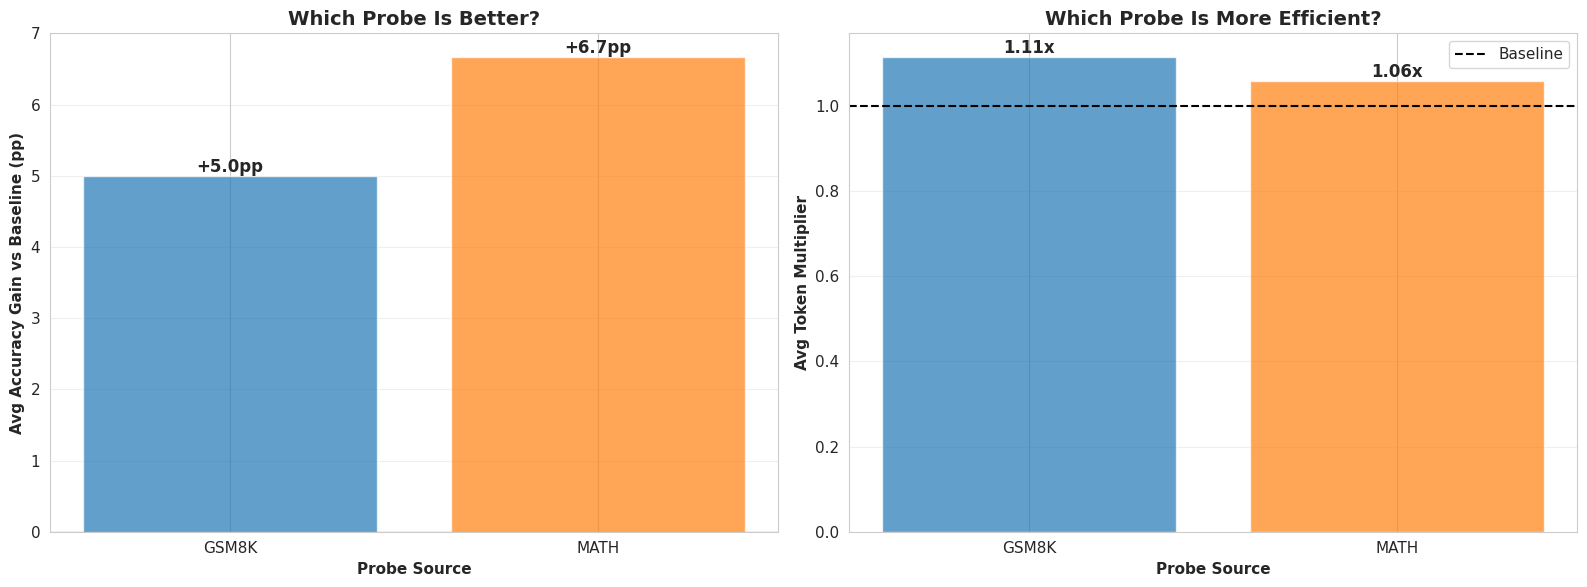


🔍 Probe verdict:

GSM8K probe:
  • Avg accuracy gain: +5.0pp
  • Avg token multiplier: 1.11x
  • Avg router accuracy: 40.0%

MATH probe:
  • Avg accuracy gain: +6.7pp
  • Avg token multiplier: 1.06x
  • Avg router accuracy: 41.7%


In [6]:
if df is not None and 'probe_source' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    probe_comparison = df.groupby('probe_source').agg({
        'router_vs_baseline': 'mean',
        'token_multiplier': 'mean',
        'router_acc': 'mean',
        'baseline_acc': 'mean'
    }).reset_index()
    
    # Left: Average accuracy gain by probe
    bars = axes[0].bar(probe_comparison['probe_source'], 
                       probe_comparison['router_vs_baseline'],
                       color=['C0', 'C1'], alpha=0.7)
    axes[0].set_ylabel('Avg Accuracy Gain vs Baseline (pp)', fontweight='bold')
    axes[0].set_xlabel('Probe Source', fontweight='bold')
    axes[0].set_title('Which Probe Is Better?', fontsize=14, fontweight='bold')
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:+.1f}pp',
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=12, fontweight='bold')
    
    # Right: Token efficiency by probe
    bars2 = axes[1].bar(probe_comparison['probe_source'], 
                        probe_comparison['token_multiplier'],
                        color=['C0', 'C1'], alpha=0.7)
    axes[1].set_ylabel('Avg Token Multiplier', fontweight='bold')
    axes[1].set_xlabel('Probe Source', fontweight='bold')
    axes[1].set_title('Which Probe Is More Efficient?', fontsize=14, fontweight='bold')
    axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, label='Baseline')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}x',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🔍 Probe verdict:")
    for _, row in probe_comparison.iterrows():
        print(f"\n{row['probe_source']} probe:")
        print(f"  • Avg accuracy gain: {row['router_vs_baseline']:+.1f}pp")
        print(f"  • Avg token multiplier: {row['token_multiplier']:.2f}x")
        print(f"  • Avg router accuracy: {row['router_acc']:.1%}")

## 5. Summary Stats

The TL;DR of what we learned.

In [7]:
if df is not None:
    print("="*80)
    print("📊 PIKA ROUTER SUMMARY".center(80))
    print("="*80)
    
    print("\n🎯 ACCURACY:")
    print(f"  • Best result: {df.loc[df['router_acc'].idxmax(), 'dataset']} @ {df['router_acc'].max():.1%}")
    print(f"  • Worst result: {df.loc[df['router_acc'].idxmin(), 'dataset']} @ {df['router_acc'].min():.1%}")
    print(f"  • Average gain over baseline: {df['router_vs_baseline'].mean():+.1f}pp")
    print(f"  • Configs with positive gain: {len(df[df['router_vs_baseline'] > 0])}/{len(df)}")
    
    print("\n💰 COST:")
    print(f"  • Average token multiplier: {df['token_multiplier'].mean():.2f}x")
    print(f"  • Best efficiency: {df.loc[df['token_multiplier'].idxmin(), 'dataset']} @ {df['token_multiplier'].min():.2f}x")
    print(f"  • Worst efficiency: {df.loc[df['token_multiplier'].idxmax(), 'dataset']} @ {df['token_multiplier'].max():.2f}x")
    
    df['router_gap_to_upper'] = df['upper_acc'] - df['router_acc']
    print("\n🏆 GAP TO UPPER BOUND:")
    print(f"  • Average gap: {(df['router_gap_to_upper'] * 100).mean():.1f}pp")
    print(f"  • Smallest gap: {df.loc[df['router_gap_to_upper'].idxmin(), 'dataset']} @ {(df['router_gap_to_upper'].min() * 100):.1f}pp")
    print(f"  • Largest gap: {df.loc[df['router_gap_to_upper'].idxmax(), 'dataset']} @ {(df['router_gap_to_upper'].max() * 100):.1f}pp")
    
    print("\n" + "="*80)
    print("\n💡 What does this mean?")
    if df['router_vs_baseline'].mean() > 0 and df['token_multiplier'].mean() < 1.5:
        print("✅ PIKA is doing its job - better accuracy without crazy token usage")
    elif df['router_vs_baseline'].mean() > 0:
        print("⚠️  We're getting better accuracy but burning tokens. Might be worth it.")
    elif df['token_multiplier'].mean() < 1.0:
        print("⚠️  We're saving tokens but accuracy isn't improving. Probe might be bad.")
    else:
        print("❌ We're worse on both fronts. Something is broken.")
    
    print("\n" + "="*80)

                             📊 PIKA ROUTER SUMMARY                              

🎯 ACCURACY:
  • Best result: E2H-GSM8K @ 93.3%
  • Worst result: AIME_2025 @ 6.7%
  • Average gain over baseline: +5.8pp
  • Configs with positive gain: 6/8

💰 COST:
  • Average token multiplier: 1.09x
  • Best efficiency: GSM_HARD @ 0.75x
  • Worst efficiency: AIME_2025 @ 1.51x

🏆 GAP TO UPPER BOUND:
  • Average gap: 0.8pp
  • Smallest gap: AIME_2025 @ 0.0pp
  • Largest gap: AIME_1983_2024 @ 6.7pp


💡 What does this mean?
✅ PIKA is doing its job - better accuracy without crazy token usage



## What's Next?

Based on these results:
1. If we're on the Pareto frontier → ship it
2. If we're not → tune thresholds or get a better probe
3. If probe source matters → stick with the winner
4. If we're burning tokens for nothing → reconsider the whole approach

That's it.